# Create Piece Dataset

In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
import torch

import sys
sys.path.append('/home/robmulla/Repos/yolov5')
from models.common import DetectMultiBackend
from utils.torch_utils import select_device


import skimage
from skimage import exposure

In [6]:
%matplotlib inline

In [7]:
# Capture the video
vid = cv2.VideoCapture('../data/piece_videos/black-pawn.MOV')

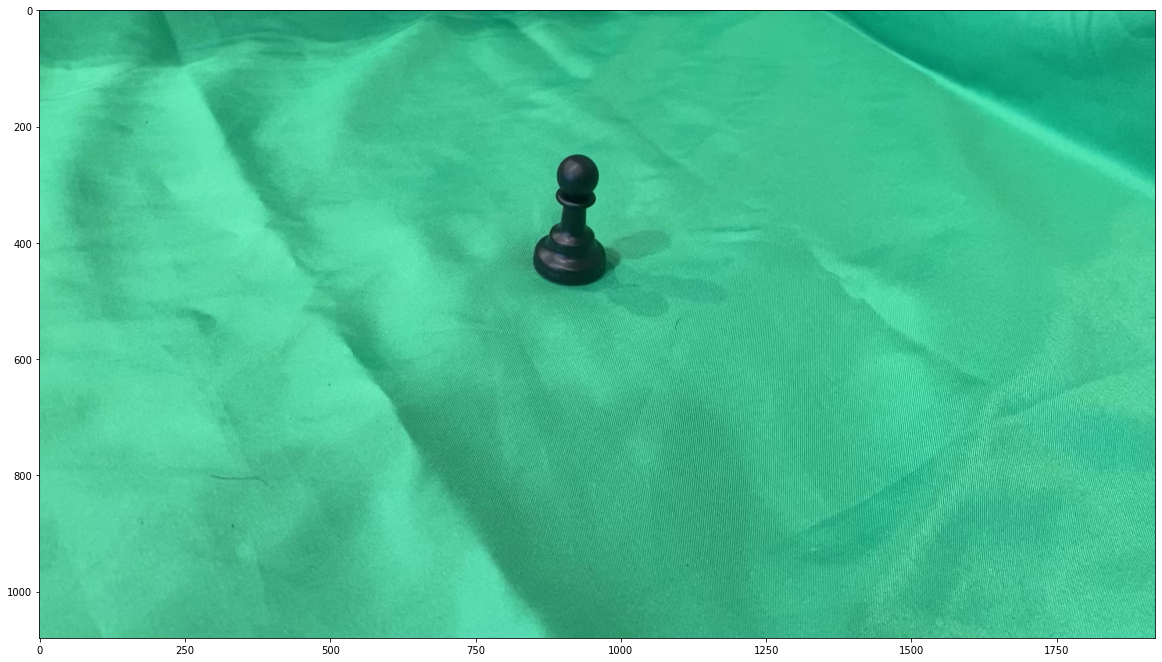

In [8]:
ret, img = vid.read()
fig, ax =  plt.subplots(figsize=(20, 20))
plt.imshow(img[:,:,::-1])
plt.show()
vid.release()

# Remove the Green Background

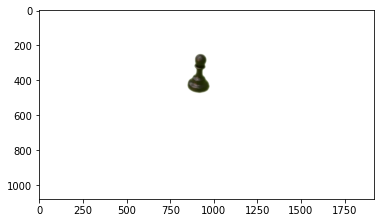

In [12]:
# convert to LAB
lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)

# extract A channel
A = lab[:,:,1]

# threshold A channel
thresh = cv2.threshold(A, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# blur threshold image
blur = cv2.GaussianBlur(thresh, (0,0), sigmaX=5, sigmaY=5, borderType = cv2.BORDER_DEFAULT)

# stretch so that 255 -> 255 and 127.5 -> 0
mask = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255)).astype(np.uint8)

# add mask to image as alpha channel
result = img.copy()
result = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA)
result[:,:,3] = mask

plt.imshow(result)
plt.show()

# Try to run yolov5 object detection on this.

In [13]:
weights = Path('/home/robmulla/Repos/yolov5/runs/train/exp13/weights/best.pt')

In [17]:
model = DetectMultiBackend(weights=weights,
                   device=select_device(0),
                           fp16=True
                  )

YOLOv5 🚀 v6.1-251-gc23a441 Python-3.8.5 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 444 layers, 86254162 parameters, 0 gradients


In [18]:
imgz = np.expand_dims(img, axis=0)
imgz = np.transpose(imgz, (0, 3, 1, 2))
imgz = torch.tensor(imgz)

# Read in Labels

In [24]:
from glob import glob

In [26]:
files = glob('/home/robmulla/Repos/yolov5/runs/detect/exp161/labels/*')

In [56]:
dfs = []
for f in files:
    df = pd.read_csv(f, header=None, delimiter=' ', names=['class','x','y','w','h'])
    video = f.split('/')[-1].split('_')[0]
    frame = int(f.split('/')[-1].split('_')[-1].strip('.txt.'))
    df['video'] = video
    df['frame'] = frame
    df['filename'] = f
    dfs.append(df)
df = pd.concat(dfs)

In [62]:
fn = df.sort_values('frame')['filename'].values[0]

In [65]:
vid = cv2.VideoCapture('/home/robmulla/Repos/chessboard-vision/data/piece_videos/black-knight.MOV')

In [67]:
frame = 1
ret, img = vid.read()


# TODO - Bounding Box

In [76]:
height = img.shape[0]
width = img.shape[1]

In [101]:
from matplotlib.patches import Rectangle


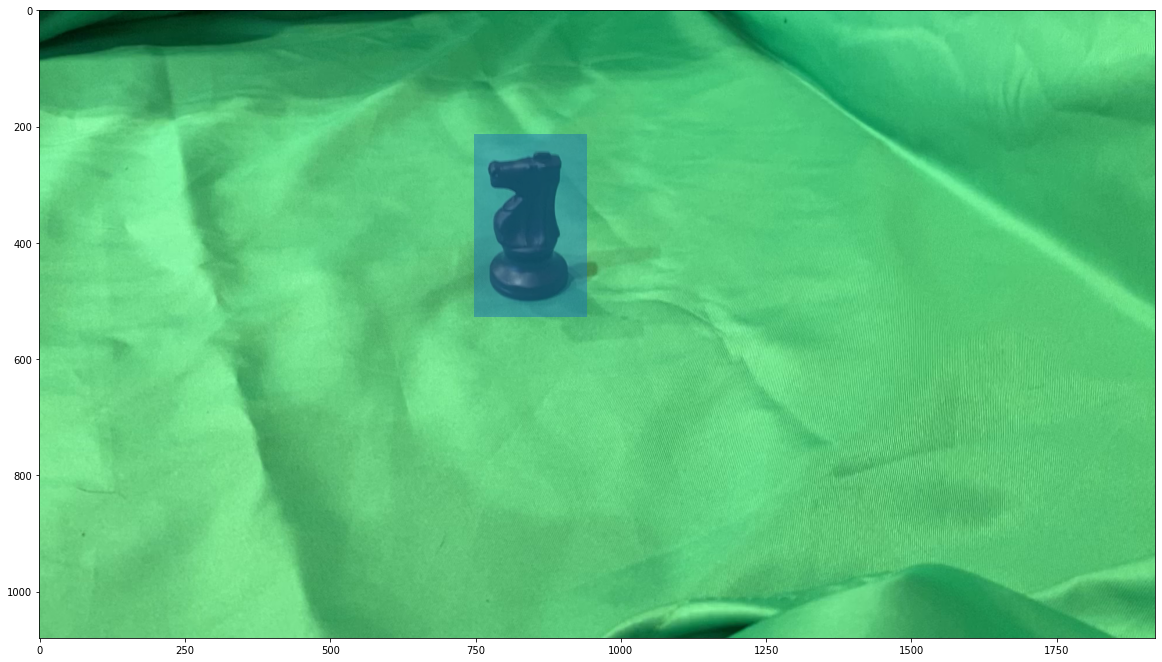

In [111]:
x = df.sort_values('frame').values[0][1]
y = df.sort_values('frame').values[0][2]
w = df.sort_values('frame').values[0][3]
h = df.sort_values('frame').values[0][4]
x *= width
y *= height
w *= width
h *= height


rect = Rectangle((x-w/2, y-h/2), width=w, height=h, alpha=0.5)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img[:,:,::-1])
ax.add_patch(rect)